In [127]:
!pip install rdkit

In [128]:
from torch_geometric.datasets import MoleculeNet
dataset = MoleculeNet(root='', name='ESOL')
dataset.num_features, dataset.num_classes 

(9, 734)

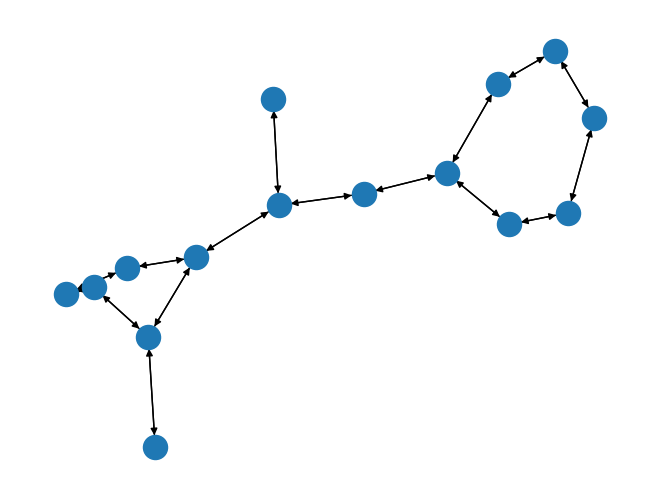

In [129]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
nx.draw(to_networkx(dataset[1]))
plt.show()

In [130]:
from torch_geometric.loader import DataLoader
data_load = DataLoader(dataset, batch_size=32, drop_last=True)

In [131]:
for batch in data_load:
    print(batch, len(data_load), len(dataset))
    break

DataBatch(x=[452, 9], edge_index=[2, 938], edge_attr=[938, 3], smiles=[32], y=[32, 1], batch=[452], ptr=[33]) 35 1128


In [132]:
import torch
import torch_geometric
# from torch_scatter import scatter_mean
from torch_geometric.nn import global_mean_pool
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.gnn1 = torch_geometric.nn.GCNConv(dataset.num_features, 4)
        self.gnn2 = torch_geometric.nn.GCNConv(4, dataset.num_classes)
        self.last = torch.nn.Linear(dataset.num_classes, 1)
    def forward(self, x, edge_index, batch):
        x = self.gnn1(x, edge_index)
        x = torch.nn.functional.relu(x)

        x = self.gnn2(x, edge_index)
        x = torch.nn.functional.relu(x)
        
        x = global_mean_pool(x, batch)
        x = torch.nn.functional.dropout(x, p=0.3, training=self.training)
#         print(x.shape)
        return self.last(x)

In [ ]:
model = Network()
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.HuberLoss()
num_epochs = 25
for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    for batch in data_load:
#         print('num_graphs:',batch.num_graphs)
        score = model(torch.tensor(batch.x, dtype=torch.float) , batch.edge_index, batch.batch)
#         print(score.shape, batch.y.view(-1).shape)
        loss = criterion(score, batch.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss+=loss
    print(f'Loss at epoch {epoch} is: {epoch_loss}')

C:\Users\harsh\AppData\Local\Temp\ipykernel_22800\1259604232.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  score = model(torch.tensor(batch.x, dtype=torch.float) , batch.edge_index, batch.batch)


Loss at epoch 1 is: 84.1797103881836
Loss at epoch 2 is: 62.107582092285156
Loss at epoch 3 is: 46.334476470947266
Loss at epoch 4 is: 44.4378776550293
Loss at epoch 5 is: 44.00954055786133


In [ ]:
model.eval()
print(dataset[4].x.shape)
for i in DataLoader(torch.utils.data.Subset(dataset, [4])):
    print(model(torch.tensor(i.x, dtype=torch.float), i.edge_index, i.batch), i.y, i.batch)